<a href="https://colab.research.google.com/github/alexmal2804/hwds/blob/master/course_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курсовой проект
## Исследование измерений краниального и постраниального скелетов с целью определения возрастной, рассовой и половой принадлежности человека

Исследование данных замеров краниального и посткраниального скелета из базы данных, составленной в ходе судебно-медицинских дел США с целью определить половую, рассовую и возрастную принадлежность индивида. Для формирования и обучения модели необходимо подготовить данные (DataSet объединен из нескольких таблиц разного формата, данные содержат большое число пропусков, несбалансированные), а затем применить методы логистической регрессии, KNN и взвешенной лог. регрессии для определения пола, расового и возрастного состава выборки соответственно.

Также научим модель CatBoost определять по данным замеров возраст индивида.

Задача исследования замеров скелета интересна с академической точки зрения и позволяет осуществлять исследования в антропологии (в т.ч. в медицине и палеоантрополгии). 
Также исследование данных и аналогичных замеров  может быть использовано в рамках задачи формирования компьютерных изображений и в рамках идентификации индивида. 

##Описание входного DataSet
https://www.icpsr.umich.edu/web/NACJD/studies/2581/versions/V1#

Database for Forensic Anthropology in the United States, 1962-1991 (ICPSR 2581)

Этот проект был осуществлен с целью создания компьютеризированной скелетной базы данных, составленной в ходе судебно-медицинских дел, чтобы отразить нынешнее этническое разнообразие и демографическую структуру населения Соединенных Штатов. Цель состояла в том, чтобы накопить скелетную выборку, достаточно разнообразную, чтобы отразить различные социально-экономические группы населения в целом из разных географических регионов страны, чтобы исследователи могли разработать стандарты, используемые для скелетной идентификации. 

In [53]:
# Импорт необходимых для работы модулей
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

##Загружаем DataSet
Используемый набор данных на ресурсе был представлен в виде 7  DataSet в формате "stata". Данные в датасетах были связаны первичным ключом 'FDN'. Необходимые для анализа данные были предварительно объединены в R-Studio и импортированы в csv.

Dataset c обработанными результатами измерений предварительно загружен на Githab. Импортируем его в DataFrame и осуществим подготовку загруженных данных для использования в моделях.

In [54]:
# Импортируем в DataFrame
u = 'https://raw.githubusercontent.com/alexmal2804/hwds/master/res_data_1.csv'
df = pd.read_csv(u, delimiter=';')

In [55]:
# Покажем информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514 entries, 0 to 1513
Columns: 142 entries, FDN to CALCBR_R
dtypes: float64(121), int64(8), object(13)
memory usage: 1.6+ MB


In [56]:
# По максимальному и минимальному предполагаемому возрасту найдем среднее
# значение и добавим его как столбец в датасет
df['AVERAGEAGE'] = (abs(df['UPPERAGE']) + abs(df['LOWERAGE']))/2
df['AVERAGEAGE']

0       33.0
1       28.5
2       33.5
3       35.0
4       29.0
        ... 
1509    12.0
1510    99.0
1511    58.0
1512    31.0
1513    28.0
Name: AVERAGEAGE, Length: 1514, dtype: float64

In [57]:
# размер DataFrame
df.shape

(1514, 143)

In [58]:
# описательная статистика
df.describe()

,FDN,IDSTAT,DEATHAGE,LOWERAGE,UPPERAGE,FSTATURE,CSTATURE,FWEIGHT,CWEIGHT,GOL,BNL,BBH,XCB,WFB,ZYB,AUB,BPL,NLH,NLB,MAB,MAL,MDH,OBH,OBB,DKB,EKB,FRC,PAC,OCC,FOL,FOB,GNI,HML,TML,GOG,CDL,WRL,MRL,XRL,MLT,...,ISCHLN_R,FEMXLN_L,FEMXLN_R,FEMBLN_L,FEMBLN_R,FEMEBR_L,FEMEBR_R,FEMHDD_L,FEMHDD_R,FEMSAP_L,FEMSAP_R,FEMSTV_L,FEMSTV_R,FEMMAP_L,FEMMAP_R,FEMMTV_L,FEMMTV_R,FEMCIR_L,FEMCIR_R,TIBXLN_L,TIBXLN_R,TIBPEB_L,TIBPEB_R,TIBDEB_L,TIBDEB_R,TIBNFX_L,TIBNFX_R,TIBNFT_L,TIBNFT_R,TIBCIR_L,TIBCIR_R,FIBXLN_L,FIBXLN_R,FIBMDM_L,FIBMDM_R,CALCXL_L,CALCXL_R,CALCBR_L,CALCBR_R,AVERAGEAGE
count,1514.000000,1509.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1514.000000,1336.000000,1293.000000,1300.000000,1339.000000,1316.000000,1289.000000,1137.000000,1194.000000,1258.000000,1278.000000,1195.000000,1183.000000,1287.000000,1263.000000,1276.000000,1251.000000,1043.000000,1286.000000,1292.000000,1276.000000,1271.000000,1026.000000,762.000000,477.000000,486.000000,779.000000,749.000000,775.000000,199.000000,678.000000,647.000000,...,498.000000,713.000000,679.000000,650.000000,625.000000,599.000000,548.000000,649.000000,590.000000,690.000000,642.000000,690.000000,642.000000,676.000000,617.000000,677.000000,618.000000,391.000000,330.000000,666.000000,624.000000,558.000000,476.000000,562.000000,478.000000,652.000000,572.000000,629.000000,547.000000,394.000000,311.000000,574.000000,544.000000,369.000000,297.000000,423.00000,397.000000,325.000000,304.000000,1514.000000
mean,757.802510,1.571902,59.321004,43.999339,48.684941,821.230515,909.817041,841.106341,947.000000,181.527695,100.794277,135.626154,137.979836,94.892857,126.665632,120.192612,96.128978,50.649444,24.209703,62.189121,53.206255,29.275835,33.776722,38.588558,21.812950,96.481304,110.888025,114.720588,97.400470,35.934697,30.021442,32.207349,29.587002,11.104938,93.712452,113.400534,30.827097,40.618090,58.797935,75.562597,...,84.096386,449.037868,448.262150,453.364615,452.344000,79.677796,80.239051,45.485362,45.920339,26.860870,26.750779,30.292754,30.289720,28.693787,28.643436,25.847858,25.577670,85.984655,86.272727,372.518018,373.176282,74.557348,74.516807,49.067616,49.399582,33.911043,33.718531,24.146264,24.254113,92.512690,92.122186,365.925087,364.329044,14.663957,15.000000,82.21513,82.372796,42.581538,42.736842,46.381770
std,437.707694,0.773161,33.946792,28.036151,29.889737,340.870774,256.863205,332.739457,204.765518,9.120869,6.382377,7.192413,6.574993,5.373070,8.478731,6.695254,7.308903,4.164517,2.549402,5.428480,4.908440,4.578253,2.374761,2.828010,2.981037,4.857508,5.991166,7.190348,6.013603,2.741283,2.609463,4.322912,3.734812,2.027465,8.515341,8.723458,3.978110,5.039728,7.961254,7.777002,...,9.990274,62.081226,64.708415,40.893876,41.839533,8.034917,9.226748,4.271299,4.418908,3.483872,3.833941,3.600287,4.130121,4.028347,4.510730,3.846025,4.145016,10.238428,10.669881,52.134013,51.326460,7.822040,8.210759,5.775267,5.883331,5.000283,5.108916,3.696388,3.733738,11.653221,12.116552,52.433782,52.052214,2.165898,2.434271,6.73771,6.798475,4.229923,4.235224,27.873882
min,1.000000,1.000000,0.000000,-8.000000,-8.000000,91.000000,89.000000,36.000000,60.000000,93.000000,47.000000,75.000000,86.000000,51.000000,53.000000,86.000000,45.000000,17.000000,12.000000,29.000000,22.000000,5.000000,18.000000,20.000000,10.000000,73.000000,50.000000,67.000000,52.000000,19.000000,11.000000,13.000000,16.000000,6.000000,48.000000,63.000000,13.000000,28.000000,18.000000,43.000000,...,15.000000,31.000000,30.000000,82.000000,71.000000,12.000000,12.000000,22.000000,26.000000,6.000000,6.000000,6.000000,6.000000,5.000000,5.000000,4.000000,4.000000,2.000000,2.000000,27.000000,27.000000,10.000000,10.000000,6.000000,7.000000,5.000000,4.000000,4.000000,4.000000,3.000000,2.000000,25.000000,41.000000,4.000000,4.000000,41.00000,41.000000,22.000000,22.000000,0.000000
25%,379.250000,1.000000,27.000000,23.000000,25.000000,999.000000,999.000000,999.000000,999.000000,176.000000,97.000000,131.000000,133.000000,92.000000,12


##Подготовка данных
Т.к. нам нужны не все столбцы в представленном DataSet, а только результаты измерений на которых будем обучать модель и категориальные столбцы со значением целевой функции - удалим те, которые не будут использоваться:

In [59]:
# Удаляем неиспользуемые столбцы, оставля только те,
# которые будут использоваться в моделях кластеризации
df_drop_cols = df.drop(columns=['AVERAGEAGE', 'FDN', 'CONTRIB', 'CURATOR',
                                'RECORDER', 'DATEREC', 'IDSTAT', 'SEXSTAT',
                                'RACESTAT', 'ETHNIC', 'DOB_MODA', 'DOB_YR',
                                'DEATHAGE', 'LOWERAGE', 'UPPERAGE', 'FSTATURE',
                                'CSTATURE', 'FWEIGHT', 'CWEIGHT', 'DATPOSID'])
df_drop_cols.head()

,SEX,RACE,AGEGROUP,GOL,BNL,BBH,XCB,WFB,ZYB,AUB,BPL,NLH,NLB,MAB,MAL,MDH,OBH,OBB,DKB,EKB,FRC,PAC,OCC,FOL,FOB,GNI,HML,TML,GOG,CDL,WRL,MRL,XRL,MLT,MAN,UFHT,UFBR,CLAXLN_L,CLAXLN_R,CLAAPD_L,...,ISCHLN_L,ISCHLN_R,FEMXLN_L,FEMXLN_R,FEMBLN_L,FEMBLN_R,FEMEBR_L,FEMEBR_R,FEMHDD_L,FEMHDD_R,FEMSAP_L,FEMSAP_R,FEMSTV_L,FEMSTV_R,FEMMAP_L,FEMMAP_R,FEMMTV_L,FEMMTV_R,FEMCIR_L,FEMCIR_R,TIBXLN_L,TIBXLN_R,TIBPEB_L,TIBPEB_R,TIBDEB_L,TIBDEB_R,TIBNFX_L,TIBNFX_R,TIBNFT_L,TIBNFT_R,TIBCIR_L,TIBCIR_R,FIBXLN_L,FIBXLN_R,FIBMDM_L,FIBMDM_R,CALCXL_L,CALCXL_R,CALCBR_L,CALCBR_R
0,F,B,A,171.0,92.0,122.0,130.0,92.0,117.0,112.0,96.0,50.0,25.0,65.0,56.0,33.0,34.0,40.0,21.0,92.0,102.0,110.0,85.0,38.0,28.0,37.0,31.0,8.0,92.0,NaN,30.0,NaN,NaN,79.0,130.0,69.0,97.0,NaN,140.0,NaN,...,77.0,NaN,467.0,NaN,462.0,NaN,72.0,NaN,40.0,NaN,24.0,NaN,26.0,NaN,28.0,NaN,24.0,NaN,80.0,NaN,392.0,NaN,68.0,NaN,47.0,NaN,32.0,NaN,20.0,NaN,82.0,NaN,383.0,NaN,15.0,NaN,NaN,NaN,NaN,NaN
1,M,B,A,185.0,NaN,NaN,NaN,92.0,122.0,NaN,NaN,50.0,22.0,NaN,NaN,32.0,32.0,38.0,NaN,96.0,NaN,114.0,NaN,NaN,NaN,NaN,29.0,10.0,94.0,113.0,32.0,NaN,62.0,84.0,125.0,69.0,102.0,153.0,160.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,81.0,81.0,45.0,NaN,30.0,29.0,31.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,422.0,418.0,NaN,16.0,84.0,85.0,47.0,46.0
2,M,W,A,172.0,97.0,137.0,138.0,93.0,127.0,122.0,94.0,51.0,25.0,59.0,51.0,34.0,35.0,39.0,21.0,94.0,105.0,107.0,108.0,36.0,32.0,31.0,29.0,11.0,97.0,121.0,30.0,NaN,60.0,74.0,127.0,68.0,NaN,153.0,144.0,12.0,...,91.0,92.0,453.0,454.0,450.0,453.0,88.0,89.0,49.0,51.0,30.0,30.0,33.0,33.0,30.0,31.0,28.0,28.0,90.0,91.0,366.0,366.0,82.0,82.0,57.0,55.0,36.0,36.0,26.0,26.0,98.0,95.0,360.0,360.0,17.0,16.0,91.0,91.0,46.0,46.0
3,F,W,A,185.0,107.0,143.0,NaN,101.0,122.0,119.0,97.0,50.0,NaN,57.0,53.0,31.0,36.0,42.0,24.0,NaN,117.0,113.0,100.0,33.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN,NaN,NaN,NaN,...,NaN,NaN,435.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,342.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F,B,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.0,131.0,12.0,...,82.0,83.0,410.0,NaN,402.0,NaN,77.0,77.0,43.0,42.0,26.0,26.0,25.0,25.0,26.0,NaN,21.0,NaN,73.0,NaN,348.0,346.0,75.0,75.0,46.0,46.0,29.0,28.0,21.0,20.0,78.0,76.0,344.0,342.0,14.0,15.0,79.0,82.0,38.0,39.0


Мы видим, что в DataSet довольно много пустых значений в ячейках с замерами. Это объясняется тем, что датасет является результатом оцифровывания сделанных вручную записей за период с 1962 по 1991 год, источником которых были фрагментарные данные. 
Т.к. строки в которых отсутствуют замеры или кол-во замеров невелико, несут мало информации - удаляем из датасета те записи, где количество незаполненных измерений  больше $\frac{2}{3}$ от общего числа замеров.

In [60]:
# Подключаем класс для предобработки данных
from sklearn import preprocessing


# Напишем функцию, которая принимает на вход DataFrame,
# осуществляет подсчет None в числовых полях и удаляет те строки,
# где кол-во ячеек  в полях numberic больше 2/3
def drop_null_records(input_df):
    # копируем нашу исходную таблицу
    result = input_df.copy()
    # определим общее число измерений в DataFrame
    numberic_cols = result._get_numeric_data().columns
    print(f'Количество измерений в исходном DataFrame: {len(numberic_cols)}')
    # подсчитаем число None в каждой строке и оставим только те,
    # где релевантные данные составляют больше 2/3
    result['def_measure'] = df[numberic_cols].count(axis=1)
    result = result[result['def_measure'] >= 40]
    result = result.drop('def_measure', axis=1)
    return result

In [61]:
# Удаляем строки с малым числом измерений в нашем датафрейме
df_without_null = drop_null_records(df_drop_cols)

Количество измерений в исходном DataFrame: 120


В оставшихся записях заполним пустые значения средним по столбцу

In [62]:
# Заполним пустые значения средним по столбцу
df_without_null.fillna(df_without_null.mean(), inplace=True)

Удалим строки с пустыми значениями в столбцах, которые будем использовать в качестве целевой функции и выведем полученный DataFrame

In [63]:
# Удалим строки с NaN в столбцах, которые будем использовать 
# в качестве целевой функции
df_without_null = df_without_null.dropna(axis=0)

In [64]:
# Размер DataFrame без удаленных записей
df_without_null.shape

(777, 123)

In [65]:
# Выведем DataFrame без None
df_without_null.head()

,SEX,RACE,AGEGROUP,GOL,BNL,BBH,XCB,WFB,ZYB,AUB,BPL,NLH,NLB,MAB,MAL,MDH,OBH,OBB,DKB,EKB,FRC,PAC,OCC,FOL,FOB,GNI,HML,TML,GOG,CDL,WRL,MRL,XRL,MLT,MAN,UFHT,UFBR,CLAXLN_L,CLAXLN_R,CLAAPD_L,...,ISCHLN_L,ISCHLN_R,FEMXLN_L,FEMXLN_R,FEMBLN_L,FEMBLN_R,FEMEBR_L,FEMEBR_R,FEMHDD_L,FEMHDD_R,FEMSAP_L,FEMSAP_R,FEMSTV_L,FEMSTV_R,FEMMAP_L,FEMMAP_R,FEMMTV_L,FEMMTV_R,FEMCIR_L,FEMCIR_R,TIBXLN_L,TIBXLN_R,TIBPEB_L,TIBPEB_R,TIBDEB_L,TIBDEB_R,TIBNFX_L,TIBNFX_R,TIBNFT_L,TIBNFT_R,TIBCIR_L,TIBCIR_R,FIBXLN_L,FIBXLN_R,FIBMDM_L,FIBMDM_R,CALCXL_L,CALCXL_R,CALCBR_L,CALCBR_R
0,F,B,A,171.000000,92.000000,122.000000,130.000000,92.000000,117.000000,112.000000,96.000000,50.000000,25.00000,65.000000,56.000000,33.000000,34.000000,40.000000,21.000000,92.000000,102.000000,110.000000,85.000000,38.000000,28.000000,37.000000,31.000000,8.000,92.000000,113.583333,30.000000,40.782313,58.827977,79.000000,130.000000,69.000000,97.000000,146.983019,140.000000,12.10089,...,77.000000,84.341053,467.000000,452.8688,462.000000,452.983221,72.0,80.426386,40.0,45.822142,24.0,26.880952,26.0,30.471088,28.000000,28.820557,24.000000,25.730903,80.000,86.286624,392.000000,375.616162,68.00000,74.474359,47.000000,49.373673,32.000000,33.811252,20.000000,24.342205,82.000000,92.163934,383.0,366.617871,15.00,15.013652,82.256659,82.296392,42.546032,42.728188
1,M,B,A,185.000000,101.445063,135.734722,137.972414,92.000000,122.000000,119.975232,96.316591,50.000000,22.00000,61.756881,53.589231,32.000000,32.000000,38.000000,21.706134,96.000000,111.132497,114.000000,97.765278,36.209722,30.193701,32.313356,29.000000,10.000,94.000000,113.000000,32.000000,40.782313,62.000000,84.000000,125.000000,69.000000,102.000000,153.000000,160.000000,14.00000,...,84.280603,84.341053,453.110942,452.8688,453.369775,452.983221,81.0,81.000000,45.0,45.822142,30.0,29.000000,31.0,31.000000,28.761381,28.820557,25.912088,25.730903,85.904,86.286624,375.562903,375.616162,74.47048,74.474359,49.082569,49.373673,33.980707,33.811252,24.233723,24.342205,92.577128,92.163934,422.0,418.000000,14.65,16.000000,84.000000,85.000000,47.000000,46.000000
2,M,W,A,172.000000,97.000000,137.000000,138.000000,93.000000,127.000000,122.000000,94.000000,51.000000,25.00000,59.000000,51.000000,34.000000,35.000000,39.000000,21.000000,94.000000,105.000000,107.000000,108.000000,36.000000,32.000000,31.000000,29.000000,11.000,97.000000,121.000000,30.000000,40.782313,60.000000,74.000000,127.000000,68.000000,103.647202,153.000000,144.000000,12.00000,...,91.000000,92.000000,453.000000,454.0000,450.000000,453.000000,88.0,89.000000,49.0,51.000000,30.0,30.000000,33.0,33.000000,30.000000,31.000000,28.000000,28.000000,90.000,91.000000,366.000000,366.000000,82.00000,82.000000,57.000000,55.000000,36.000000,36.000000,26.000000,26.000000,98.000000,95.000000,360.0,360.000000,17.00,16.000000,91.000000,91.000000,46.000000,46.000000
4,F,B,A,182.699588,101.445063,135.734722,137.972414,95.323651,126.492938,119.975232,96.316591,50.606277,23.98169,61.756881,53.589231,29.832178,33.697872,38.808451,21.706134,96.921098,111.132497,115.239281,97.765278,36.209722,30.193701,32.313356,29.667582,11.112,93.845771,113.583333,30.840796,40.782313,58.827977,75.701754,125.969388,69.675507,103.647202,137.000000,131.000000,12.00000,...,82.000000,83.000000,410.000000,452.8688,402.000000,452.983221,77.0,77.000000,43.0,42.000000,26.0,26.000000,25.0,25.000000,26.000000,28.820557,21.000000,25.730903,73.000,86.286624,348.000000,346.000000,75.00000,75.000000,46.000000,46.000000,29.000000,28.000000,21.000000,20.000000,78.000000,76.000000,344.0,342.000000,14.00,15.000000,79.000000,82.000000,38.000000,39.000000
7,F,W,A,177.000000,96.000000,143.000000,135.000000,90.000000,122.000000,118.000000,84.000000,47.000000,24.00000,60.000000,50.000000,31.000000,33.000000,37.000000,18.000000,90.000000,115.000000,113.000000,105.000000,34.000000,29.000000,34.000000,30.000000,11.000,90.000000,121.000000,29.000000,40.782313,52.000000,80.000000,128.000000,64.000000,101.000000,146.983019,145.489603,12.10089,...,81.000000,83.

## Преобразование категориальных признаков

In [66]:
# Подключаем класс для предобработки данных
from sklearn import preprocessing


# Используем функцию, которая принимает на вход DataFrame,
# кодирует числовыми значениями категориальные признаки
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(input_df):
    # копируем нашу исходную таблицу
    result = input_df.copy()
    encoders = {}
    for column in result.columns:
        # np.object -- строковый тип
        # если тип столбца - строка, то нужно его закодировать
        if result.dtypes[column] == np.object:
            # для колонки column создаем кодировщик
            encoders[column] = preprocessing.LabelEncoder()
            # применяем кодировщик к столбцу и перезаписываем столбец
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders


# датафрейм содержит закодированные кат. признаки
df_encoded, encoders = number_encode_features(df_without_null)
df_encoded.head()

,SEX,RACE,AGEGROUP,GOL,BNL,BBH,XCB,WFB,ZYB,AUB,BPL,NLH,NLB,MAB,MAL,MDH,OBH,OBB,DKB,EKB,FRC,PAC,OCC,FOL,FOB,GNI,HML,TML,GOG,CDL,WRL,MRL,XRL,MLT,MAN,UFHT,UFBR,CLAXLN_L,CLAXLN_R,CLAAPD_L,...,ISCHLN_L,ISCHLN_R,FEMXLN_L,FEMXLN_R,FEMBLN_L,FEMBLN_R,FEMEBR_L,FEMEBR_R,FEMHDD_L,FEMHDD_R,FEMSAP_L,FEMSAP_R,FEMSTV_L,FEMSTV_R,FEMMAP_L,FEMMAP_R,FEMMTV_L,FEMMTV_R,FEMCIR_L,FEMCIR_R,TIBXLN_L,TIBXLN_R,TIBPEB_L,TIBPEB_R,TIBDEB_L,TIBDEB_R,TIBNFX_L,TIBNFX_R,TIBNFT_L,TIBNFT_R,TIBCIR_L,TIBCIR_R,FIBXLN_L,FIBXLN_R,FIBMDM_L,FIBMDM_R,CALCXL_L,CALCXL_R,CALCBR_L,CALCBR_R
0,0,1,0,171.000000,92.000000,122.000000,130.000000,92.000000,117.000000,112.000000,96.000000,50.000000,25.00000,65.000000,56.000000,33.000000,34.000000,40.000000,21.000000,92.000000,102.000000,110.000000,85.000000,38.000000,28.000000,37.000000,31.000000,8.000,92.000000,113.583333,30.000000,40.782313,58.827977,79.000000,130.000000,69.000000,97.000000,146.983019,140.000000,12.10089,...,77.000000,84.341053,467.000000,452.8688,462.000000,452.983221,72.0,80.426386,40.0,45.822142,24.0,26.880952,26.0,30.471088,28.000000,28.820557,24.000000,25.730903,80.000,86.286624,392.000000,375.616162,68.00000,74.474359,47.000000,49.373673,32.000000,33.811252,20.000000,24.342205,82.000000,92.163934,383.0,366.617871,15.00,15.013652,82.256659,82.296392,42.546032,42.728188
1,1,1,0,185.000000,101.445063,135.734722,137.972414,92.000000,122.000000,119.975232,96.316591,50.000000,22.00000,61.756881,53.589231,32.000000,32.000000,38.000000,21.706134,96.000000,111.132497,114.000000,97.765278,36.209722,30.193701,32.313356,29.000000,10.000,94.000000,113.000000,32.000000,40.782313,62.000000,84.000000,125.000000,69.000000,102.000000,153.000000,160.000000,14.00000,...,84.280603,84.341053,453.110942,452.8688,453.369775,452.983221,81.0,81.000000,45.0,45.822142,30.0,29.000000,31.0,31.000000,28.761381,28.820557,25.912088,25.730903,85.904,86.286624,375.562903,375.616162,74.47048,74.474359,49.082569,49.373673,33.980707,33.811252,24.233723,24.342205,92.577128,92.163934,422.0,418.000000,14.65,16.000000,84.000000,85.000000,47.000000,46.000000
2,1,5,0,172.000000,97.000000,137.000000,138.000000,93.000000,127.000000,122.000000,94.000000,51.000000,25.00000,59.000000,51.000000,34.000000,35.000000,39.000000,21.000000,94.000000,105.000000,107.000000,108.000000,36.000000,32.000000,31.000000,29.000000,11.000,97.000000,121.000000,30.000000,40.782313,60.000000,74.000000,127.000000,68.000000,103.647202,153.000000,144.000000,12.00000,...,91.000000,92.000000,453.000000,454.0000,450.000000,453.000000,88.0,89.000000,49.0,51.000000,30.0,30.000000,33.0,33.000000,30.000000,31.000000,28.000000,28.000000,90.000,91.000000,366.000000,366.000000,82.00000,82.000000,57.000000,55.000000,36.000000,36.000000,26.000000,26.000000,98.000000,95.000000,360.0,360.000000,17.00,16.000000,91.000000,91.000000,46.000000,46.000000
4,0,1,0,182.699588,101.445063,135.734722,137.972414,95.323651,126.492938,119.975232,96.316591,50.606277,23.98169,61.756881,53.589231,29.832178,33.697872,38.808451,21.706134,96.921098,111.132497,115.239281,97.765278,36.209722,30.193701,32.313356,29.667582,11.112,93.845771,113.583333,30.840796,40.782313,58.827977,75.701754,125.969388,69.675507,103.647202,137.000000,131.000000,12.00000,...,82.000000,83.000000,410.000000,452.8688,402.000000,452.983221,77.0,77.000000,43.0,42.000000,26.0,26.000000,25.0,25.000000,26.000000,28.820557,21.000000,25.730903,73.000,86.286624,348.000000,346.000000,75.00000,75.000000,46.000000,46.000000,29.000000,28.000000,21.000000,20.000000,78.000000,76.000000,344.0,342.000000,14.00,15.000000,79.000000,82.000000,38.000000,39.000000
7,0,5,0,177.000000,96.000000,143.000000,135.000000,90.000000,122.000000,118.000000,84.000000,47.000000,24.00000,60.000000,50.000000,31.000000,33.000000,37.000000,18.000000,90.000000,115.000000,113.000000,105.000000,34.000000,29.000000,34.000000,30.000000,11.000,90.000000,121.000000,29.000000,40.782313,52.000000,80.000000,128.000000,64.000000,101.000000,146.983019,145.489603,12.10089,...,81.000000,83.

In [67]:
# Выведем соответствие числовых значений закодированным
# Пол
encoders['SEX'].inverse_transform([0, 1])

array(['F', 'M'], dtype=object)

In [68]:
# Раса
encoders['RACE'].inverse_transform([0, 1, 2, 3, 4, 5])

array(['A', 'B', 'C', 'H', 'M', 'W'], dtype=object)

In [69]:
# Возрастная группа
encoders['AGEGROUP'].inverse_transform([0, 1, 2, 3, 4])

array(['A', 'C', 'F', 'I', 'S'], dtype=object)

## Удалим коррелирующие данные

In [70]:
# Построим матрицу корреляции
corr = df_encoded.corr()
corr.head()

,SEX,RACE,AGEGROUP,GOL,BNL,BBH,XCB,WFB,ZYB,AUB,BPL,NLH,NLB,MAB,MAL,MDH,OBH,OBB,DKB,EKB,FRC,PAC,OCC,FOL,FOB,GNI,HML,TML,GOG,CDL,WRL,MRL,XRL,MLT,MAN,UFHT,UFBR,CLAXLN_L,CLAXLN_R,CLAAPD_L,...,ISCHLN_L,ISCHLN_R,FEMXLN_L,FEMXLN_R,FEMBLN_L,FEMBLN_R,FEMEBR_L,FEMEBR_R,FEMHDD_L,FEMHDD_R,FEMSAP_L,FEMSAP_R,FEMSTV_L,FEMSTV_R,FEMMAP_L,FEMMAP_R,FEMMTV_L,FEMMTV_R,FEMCIR_L,FEMCIR_R,TIBXLN_L,TIBXLN_R,TIBPEB_L,TIBPEB_R,TIBDEB_L,TIBDEB_R,TIBNFX_L,TIBNFX_R,TIBNFT_L,TIBNFT_R,TIBCIR_L,TIBCIR_R,FIBXLN_L,FIBXLN_R,FIBMDM_L,FIBMDM_R,CALCXL_L,CALCXL_R,CALCBR_L,CALCBR_R
SEX,1.000000,-0.000764,-0.172142,0.464421,0.455127,0.400480,0.394543,0.333737,0.571955,0.442241,0.313160,0.387531,0.294997,0.323426,0.230456,0.438898,0.044180,0.360679,0.212484,0.401853,0.389919,0.304855,0.170188,0.270500,0.233529,0.311159,0.210524,0.162652,0.468679,0.405346,0.232681,0.156775,0.352204,0.266794,-0.060621,0.380356,0.353623,0.421484,0.421500,0.328201,...,0.456106,0.426693,0.376965,0.343942,0.424540,0.430204,0.522397,0.499485,0.637749,0.590151,0.487603,0.463425,0.466110,0.417409,0.447521,0.402974,0.506404,0.460291,0.353489,0.309473,0.367388,0.364546,0.511145,0.479333,0.441864,0.423439,0.496912,0.458049,0.449467,0.435940,0.361472,0.325569,0.352492,0.361479,0.246909,0.247348,0.390990,0.380299,0.347226,0.336694
RACE,-0.000764,1.000000,0.029144,-0.002393,0.146547,0.355554,0.203405,-0.010923,-0.089476,0.058913,-0.414270,0.097970,-0.424043,-0.448779,-0.391194,-0.068966,-0.210002,0.029417,-0.401734,-0.249013,0.148485,0.005871,0.165477,0.122863,0.331224,-0.367661,-0.236294,-0.141325,0.061375,-0.042997,-0.359554,0.004204,-0.006026,-0.323701,0.197731,-0.125309,-0.139314,-0.057308,-0.032466,-0.202886,...,0.062069,0.020967,-0.060499,-0.036652,-0.086773,-0.076243,0.048816,0.038871,0.077291,0.049720,-0.002852,0.007940,-0.014622,0.015364,-0.032669,0.008036,-0.031473,0.023180,-0.012196,0.012664,-0.095858,-0.103955,-0.031275,-0.030559,0.108837,0.031763,-0.024881,-0.025566,-0.137276,-0.122426,-0.074939,-0.043723,-0.098023,-0.064763,0.039346,0.042372,0.064331,0.039838,-0.016851,-0.022004
AGEGROUP,-0.172142,0.029144,1.000000,-0.190555,-0.105026,-0.048562,-0.216195,-0.197264,-0.293230,-0.169189,-0.103030,-0.197659,-0.254426,-0.142876,-0.158045,-0.151817,-0.116982,-0.210218,-0.151794,-0.179735,-0.165258,-0.110614,-0.092814,-0.015393,-0.048429,-0.133243,-0.134339,-0.019327,-0.224425,-0.303259,-0.038808,-0.019047,-0.220753,-0.133427,0.075325,-0.192613,-0.174498,-0.311050,-0.279336,-0.156281,...,-0.195166,-0.178937,-0.229824,-0.224222,-0.138116,-0.126641,-0.223179,-0.201300,-0.225642,-0.202509,-0.261341,-0.227677,-0.226387,-0.211267,-0.260379,-0.239960,-0.339218,-0.302766,-0.215373,-0.174346,-0.222116,-0.214408,-0.180225,-0.171957,-0.188092,-0.159534,-0.263735,-0.248138,-0.216807,-0.199331,-0.167195,-0.174535,-0.228907,-0.238504,-0.144600,-0.175414,-0.125894,-0.112023,-0.122313,-0.077679
GOL,0.464421,-0.002393,-0.190555,1.000000,0.625672,0.440269,0.297173,0.398676,0.461817,0.367032,0.462966,0.422609,0.269856,0.289858,0.393963,0.407130,0.195455,0.410823,0.221214,0.431102,0.613993,0.642712,0.411489,0.349022,0.213101,0.316864,0.185425,0.118545,0.375274,0.345520,0.240245,0.151440,0.278839,0.285441,-0.056421,0.479459,0.369448,0.397509,0.390269,0.212266,...,0.383208,0.389233,0.386486,0.346261,0.356071,0.370557,0.362209,0.351631,0.452891,0.379627,0.426732,0.402843,0.415575,0.341196,0.420561,0.391949,0.450596,0.398247,0.263255,0.257337,0.364038,0.362318,0.353694,0.324224,0.337368,0.317494,0.424371,0.371706,0.393241,0.345050,0.245579,0.212291,0.360842,0.370052,0.246674,0.210123,0.312456,0.307179,0.225555,0.250006
BNL,0.455127,0.146547,-0.105026,0.625672,1.000000,0.641872,0.270689,0.432655,0.519111,0.458028,0.580943,0.491213,0.214192,0.297277,0.386636,0.392286,0.107014,0.457826,0.178108,0.437334,0.422503,0.294417,0.323813,0.255387,0.299676,0.247122,0.140876,0.117660,0.448749,0.400596,0.295632,0.218691,0.317531,0.276508,-0.047473,0.431269,0.404094,0.417628,0.412740,0.226431,...,0.444149,0.412488,0.437013,0.40435

Найдем столбцы сильно коррелирующие между собой (коэффициент корреляции Пирсона > 0.9)

In [71]:
# Найдем столбцы сильно коррелирующие между собой
# (коэффициент корреляции Пирсона > 0.9)
r = corr.stack()[(abs(corr.stack()) > 0.9) & (corr.stack() != 1.0)]

In [72]:
print(r)

RADXLN_L  ULNXLN_L    0.926443
ULNXLN_L  RADXLN_L    0.926443
FEMXLN_L  TIBXLN_L    0.903181
TIBXLN_L  FEMXLN_L    0.903181
TIBXLN_R  FIBXLN_R    0.906980
FIBXLN_R  TIBXLN_R    0.906980
dtype: float64


In [73]:
# Удалим столбцы с высоким коэффициентом корреляции
df_encoded = df_encoded.drop(columns=['RADXLN_L', 'FEMXLN_L', 'FIBXLN_R'])
df_encoded.shape

(777, 120)

##Распределение величин по признакам

Для того, чтобы определить как распределены величины по признакам построим графики распределений по преобразованном датафрейму

In [74]:
# График распределения величин по признакам
def ditstrib_features(df, cols=5, a=5, b=5, rot="vertical", s=""):
    fig = plt.figure(figsize=(a, b))
    plt.title('Распределение величин измерений по признакам', fontsize=48)
    input_df = pd.DataFrame(df)
    rows = np.ceil(float(input_df.shape[1]) / cols)
    for i, column in enumerate(input_df.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column + " " + str(s))
        input_df[column].hist(axes=ax)
        plt.xticks(rotation=rot)
    plt.subplots_adjust(hspace=0.5, wspace=0.2)

In [75]:
# Cтроим распределение по всем данным из DataSet
ditstrib_features(df_encoded, 9, 100, 250)

На большей части графиков видим распределение близкое к нормальному.

## Логистическая регрессия для определения пола
Применим алгоритм логистической регресии из библиотеки scikit-learn чтобы обучить модель определять пол по данным измерений

Удалим неиспользуемые на этом этапе категориальные признаки

In [76]:
df_research_1 = df_encoded.drop(columns=['RACE', 'AGEGROUP'])

Веделим целевую функцию в отдельную переменную

In [77]:
y = np.array(df_research_1['SEX'])

Проверим, сбалансированы ли классы в целевой функции

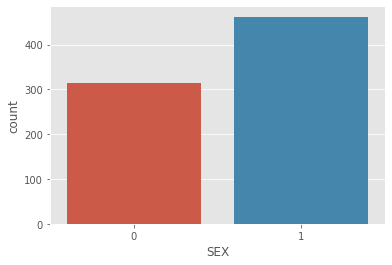

In [78]:
# Построим диаграмму распределения классов целевой функции
sns.countplot(x='SEX', data=df_research_1)


Оставим данные без балансировки

Осуществим нормализацию данных

In [79]:
# Преобразуем DataFrame в формат для обучения модели (np.array)
df_research_1 = df_research_1.drop(columns='SEX')
X = np.array(df_research_1)
X

array([[171.        ,  92.        , 122.        , ...,  82.29639175,
         42.54603175,  42.72818792],
       [185.        , 101.44506259, 135.73472222, ...,  85.        ,
         47.        ,  46.        ],
       [172.        ,  97.        , 137.        , ...,  91.        ,
         46.        ,  46.        ],
       ...,
       [194.        , 101.        , 138.        , ...,  82.29639175,
         45.        ,  42.72818792],
       [192.        ,  99.        , 134.        , ...,  86.        ,
         41.        ,  42.        ],
       [183.        ,  98.        , 146.        , ...,  82.29639175,
         47.        ,  42.72818792]])

In [80]:
# Масштабируем признаки
from sklearn.preprocessing import scale

X_norm = scale(X)
X_norm

array([[-1.39231754e+00, -1.66803609e+00, -2.07420666e+00, ...,
         7.57826722e-04, -1.31821105e-03,  5.36041143e-04],
       [ 2.69248238e-01,  1.81903395e-03,  4.75085743e-03, ...,
         5.66402607e-01,  1.66963845e+00,  1.25390446e+00],
       [-1.27363427e+00, -7.84053000e-01,  1.96269747e-01, ...,
         1.82171342e+00,  1.29447712e+00,  1.25390446e+00],
       ...,
       [ 1.33739767e+00, -7.68665264e-02,  3.47634840e-01, ...,
         7.57826722e-04,  9.19315788e-01,  5.36041143e-04],
       [ 1.10003113e+00, -4.30459763e-01, -2.57825534e-01, ...,
         7.75621076e-01, -5.81329540e-01, -2.78418777e-01],
       [ 3.18816988e-02, -6.07256382e-01,  1.55855559e+00, ...,
         7.57826722e-04,  1.66963845e+00,  5.36041143e-04]])

In [81]:
# Разобъем выборку на тестовую и обучающуюZ
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.15,
                                                    random_state=42)

Обучаем логистическу регрессию

In [82]:
# Импортируем необходимые модули
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Зададим сетку - среди каких значений выбирать наилучший параметр
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100]}
# Тип оценки
estimator_l = LogisticRegression()

# Создаем объект для обучения
gs_logistic = GridSearchCV(estimator_l, param_grid, cv=3)

# Обучаем его
gs_logistic.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [83]:
# Отобразим результаты обучения
print(gs_logistic.best_score_)
print(gs_logistic.best_params_)
print(gs_logistic.best_estimator_)

0.943939393939394
{'C': 0.1}
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Строим график оценок точности и их стандартных
 отклонений

In [84]:
# Используем функцию построения графика точности и их стандартного отклонения
def plot_scores(optimizer):
    scores = []
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([optimizer.cv_results_['params'][i]['C'],
                       optimizer.cv_results_['mean_test_score'][i],
                       optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    plt.semilogx(scores[:, 0], scores[:, 1])
    plt.fill_between(scores[:, 0], scores[:, 1]-scores[:, 2],
                     scores[:, 1]+scores[:, 2], alpha=0.3)
    plt.show()

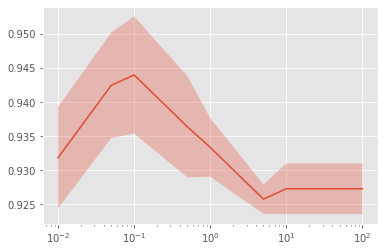

In [85]:
# Строим график точности и стд. отклонения
plot_scores(gs_logistic)

Протестируем обученную модель и применим различные метрики оценки точности модели

In [86]:
# Выполним предсказание на тестовом наборе данных
preds_logistic = gs_logistic.predict(X_test)

In [87]:
# Отобразим метрику R^2 (наилучшее возможное значение 1.0)
metrics.r2_score(y_test, preds_logistic)

0.4536114570361147

In [88]:
# Отобразим метрику MAE (наилучшее возможное значение 0.0)
metrics.median_absolute_error(y_test, preds_logistic)

0.0

In [89]:
# Отобразим метрику ROC AUC
predict_proba = gs_logistic.predict_proba(X_test)[:, 1]
AUC_1 = roc_auc_score(y_test, predict_proba)
AUC_1

0.9461394769613949

Confusion matrix:
[[38  6]
 [ 9 64]]


Text(0.5, 42.0, 'Predicted value')

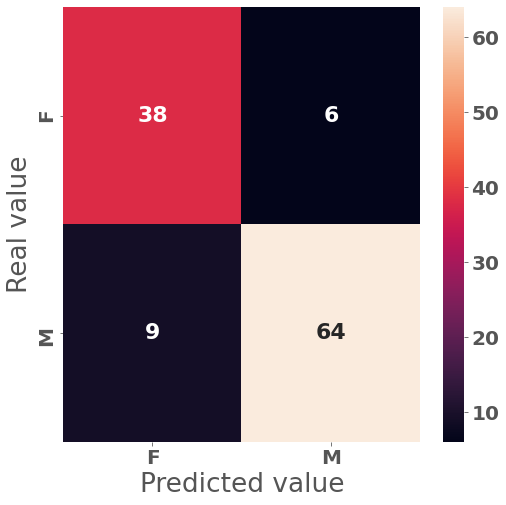

In [90]:
# Построим confusion matrix
fig = plt.figure(figsize=(8,8))
nn_mtx = metrics.confusion_matrix(y_test, preds_logistic)
print('Confusion matrix:')
print(nn_mtx)
font = {'weight' : 'bold', 'size' : 22}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d",
            xticklabels=encoders["SEX"].classes_, 
            yticklabels=encoders["SEX"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")

In [91]:
# Используем classification_report
mt = metrics.classification_report(y_test, preds_logistic)
print(mt)

              precision    recall  f1-score   support

           0       0.81      0.86      0.84        44
           1       0.91      0.88      0.90        73

    accuracy                           0.87       117
   macro avg       0.86      0.87      0.87       117
weighted avg       0.87      0.87      0.87       117



In [92]:
# Используем метрику Accuracy
metrics.accuracy_score(y_test, preds_logistic)

0.8717948717948718

##Метод k ближайших соседей при определении принадлежности к расе

 В целевой функции 'RACE' данные несбалансированы, поэтому используем следующие приемы:


*   Объединяем несколько малых групп признаков в один
*   Используем oversampling





In [93]:
# Выведем соответствие числовых данных закодированным для признака:
encoders['RACE'].inverse_transform([0, 1, 2, 3, 4, 5])

array(['A', 'B', 'C', 'H', 'M', 'W'], dtype=object)

Распределение признака раса до группировки:
5    489
1    242
3     26
4     14
0      5
2      1
Name: RACE, dtype: int64


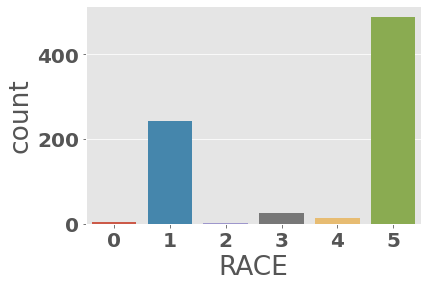

In [94]:
# Удалим неиспользуемые на этом этапе категориальные признаки
df_research_2 =  df_encoded.drop(columns=['SEX', 'AGEGROUP'])

# Выделим целевую функцию в отдельную переменную
y = np.array(df_research_2['RACE'])

# Проверим, сбалансированы ли классы в целевой функции
sns.countplot(x='RACE', data=df_research_2)
print('Распределение признака раса до группировки:')
print(df_research_2['RACE'].value_counts())

Изменим строки со значениями целевой функции равными 3, 4 и 2, т.к. обучение  модели на такой маленькой в разрезе значения функции выборке не даст необходимого результата.

В итоге в целевой функции будет три значения (1, 5 и 0), которые будут интерпретироваться как "Black", "White" и "Other".

Распределение признака раса после группировки:
5    489
1    242
0     45
Name: RACE, dtype: int64


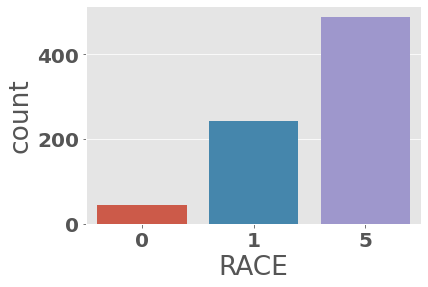

In [95]:
# Изменим строки со значениями целевой функции равными 3, 4, 0 и 2
df_research_2 = df_research_2[df_research_2['RACE'] != 2]
# Заменим значение с малым числом вхождений на одно. 
# В итоге в целевой функции будет три значения
df_research_2.loc[df_research_2['RACE'] == 3 ] = 0
df_research_2.loc[df_research_2['RACE'] == 4 ] = 0 
df_research_2.loc[df_research_2['RACE'] == 2 ] = 0 
# Посмотрим еще раз на распределение признаков
sns.countplot(x='RACE', data=df_research_2)
print('Распределение признака раса после группировки:')
print(df_research_2['RACE'].value_counts())

Данные несбалансированы, поэтому будем использовать для их балансировки метод SMOTE, который  использует oversampling


In [97]:
# Импортируем SMOTE
from imblearn.over_sampling import SMOTE

# Настраваем экземпляр класса SMOTE для балансировки данных
sm = SMOTE(random_state=42, k_neighbors=7)

In [98]:
# Выделим целевую функцию в отдельную переменную
y_1 = np.array(df_research_2['RACE'])

In [99]:
# Преобразуем DataFrame в формат для обучения модели (np.array)
df_research_2 = df_research_2.drop(columns='RACE')
X = np.array(df_research_2)
# Масштабируем признаки
from sklearn.preprocessing import scale
X_norm = scale(X)
X_norm

array([[-0.06392679, -0.18540972, -0.21855309, ...,  0.2245009 ,
         0.21907475,  0.22043682],
       [ 0.27533755,  0.22296082,  0.22877061, ...,  0.36827785,
         0.67548088,  0.55472856],
       [-0.03969362,  0.0307723 ,  0.26997921, ...,  0.68735576,
         0.57300908,  0.55472856],
       ...,
       [ 0.49343606,  0.20371791,  0.30254803, ...,  0.2245009 ,
         0.47053729,  0.22043682],
       [ 0.44496972,  0.1172451 ,  0.17227275, ...,  0.4214575 ,
         0.06065011,  0.14603548],
       [ 0.22687122,  0.0740087 ,  0.56309859, ...,  0.2245009 ,
         0.67548088,  0.22043682]])

In [100]:
# Разобъем выборку на тестовую и тренировочную
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_1, test_size=0.15, random_state=42)

In [101]:
# Осуществляем oversampling с использованием SMOTE
X_sm, y_sm = sm.fit_resample(X_train, y_train)

Используем кросс-валидацию

In [102]:
# Будем использовать модель k ближайших соседей
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
# В sklearn есть специальный модуль для работы с кросс-валидацией
from sklearn.model_selection import GridSearchCV

# Зададим сетку - среди каких значений выбирать наилучший параметр.
# перебираем по параметру <<n_neighbors>> по сетке 
knn_grid = {'n_neighbors': np.array(np.linspace(2, 101, 100), dtype='int')}
# Создаем объект кросс-валидации
gs = GridSearchCV(knn, knn_grid, cv=7)

# Обучаем его
gs.fit(X_sm, y_sm)

GridSearchCV(cv=7, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,

In [103]:
# best_params_ содержит в себе лучшие подобранные параметры, best_score_ лучшее качество
gs.best_params_, gs.best_score_

({'n_neighbors': 3}, 0.8810116481781833)

In [104]:
# импортируем и создаем knn классификатор
knn = KNeighborsClassifier(n_neighbors=gs.best_params_['n_neighbors'])
# тренируем для knn
clf_knn = knn.fit(X_sm, y_sm)
# получаем предсказание на тестовых данных
y_knn = clf_knn.predict(X_test)

Для оценки точности модели используем метрику classification report

In [105]:
print(metrics.classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.65      0.79      0.72        43
           5       0.83      0.73      0.77        66

    accuracy                           0.76       117
   macro avg       0.83      0.80      0.81       117
weighted avg       0.78      0.76      0.76       117



Построим confusion matrix

Confusion matrix:
[[ 7  0  1]
 [ 0 34  9]
 [ 0 18 48]]


Text(0.5, 42.0, 'Predicted value')

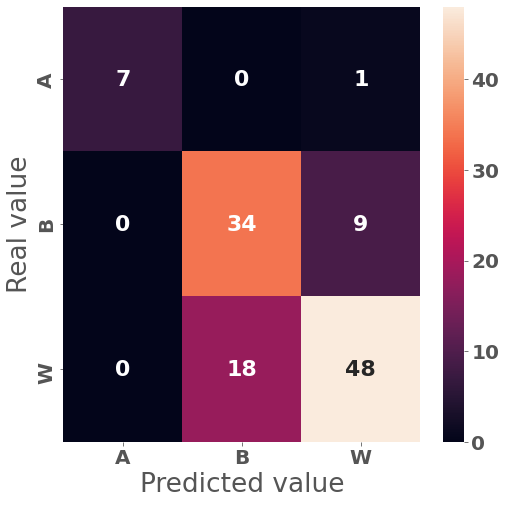

In [106]:
# Построим confusion matrix
fig = plt.figure(figsize=(8, 8))
nn_mtx = metrics.confusion_matrix(y_test, y_knn)
print('Confusion matrix:')
print(nn_mtx)
font = {'weight': 'bold', 'size': 22}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d",
            xticklabels=encoders["RACE"].classes_[[0, 1, 5]], 
            yticklabels=encoders["RACE"].classes_[[0, 1, 5]])
plt.ylabel("Real value")
plt.xlabel("Predicted value")

In [107]:
# Используем метрику Accuracy
metrics.accuracy_score(y_test, y_knn)

0.7606837606837606

##Взвешенная логистическая регрессия при определении принадлежности к возрастной группе

In [108]:
# Выведем соответствие числовых данных закодированным для признака:
encoders['AGEGROUP'].inverse_transform([0, 1, 2, 3, 4])

array(['A', 'C', 'F', 'I', 'S'], dtype=object)

Распределение признака возрастная группа до группировки:
0    710
4     43
1     20
3      3
2      1
Name: AGEGROUP, dtype: int64


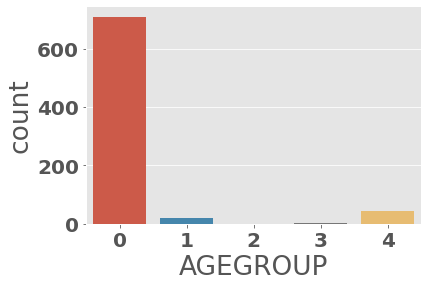

In [109]:
# Удалим неиспользуемые на этом этапе категориальные признаки
df_research_3 =  df_encoded.drop(columns=['SEX', 'RACE'])
# Проверим, сбалансированы ли классы в целевой функции
print('Распределение признака возрастная группа до группировки:')
print(df_research_3['AGEGROUP'].value_counts())
sns.countplot(x='AGEGROUP', data=df_research_3)

Данные несбалансированы, поэтому будем использовать для их балансировки *sklearn.linear_model.LogisticRegression* с параметром *class_weight = 'balanced'*.

*'balanced'* - это  режим, который  осуществляет автоматическую настройков весов по числу вхождений значений целевой функции для класса, отнесенному к  частотам классов во входных данных: $\frac{n\_samples}{n\_classes \cdot np.bincount (y)}$, где $np.bincount (y)$ - функция из библиотеки *numpy*, которая возвращает количество вхождений значения в массив.

Изменим строки со значениями целевой функции равными 1, 2,  и 3, т.к. обучить модель на такой маленькой в разрезе значения функции выборке невозможно

Объединим значения с малым числом значений. 

В итоге в целевой функции будет три значения, которые будут интерпретироваться как "A", "S" и "C"

Распределение признака возрастная группа после группировки:
0    710
4     43
1     24
Name: AGEGROUP, dtype: int64


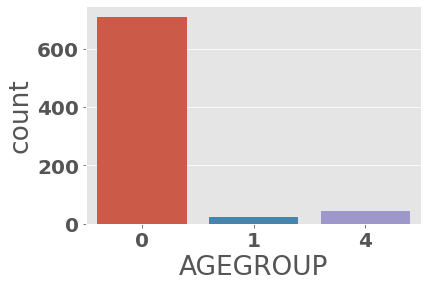

In [110]:
# Изменим строки со значениями целевой функции равными 1, 2 и 3.
# Объединим значения с малым числом значений.
# В итоге в целевой функции будет три значения.
df_research_3.loc[df_research_3['AGEGROUP'] == 2 ] = 1
df_research_3.loc[df_research_3['AGEGROUP'] == 3 ] = 1
# Выведем распределение признаков
print('Распределение признака возрастная группа после группировки:')
print(df_research_3['AGEGROUP'].value_counts())
sns.countplot(x='AGEGROUP', data=df_research_3)

In [111]:
# Выделим целевую функцию в отдельную переменную
y_2 = np.array(df_research_3['AGEGROUP'])

In [112]:
# Преобразуем DataFrame в формат для обучения модели (np.array)
df_research_3 = df_research_3.drop(columns='AGEGROUP')
X = np.array(df_research_3)
# Масштабируем признаки
from sklearn.preprocessing import scale
X_norm = scale(X)
X_norm

array([[-0.70109431, -0.98437766, -1.12181339, ...,  0.05606552,
         0.05267937,  0.05451349],
       [ 0.20464721,  0.05410157,  0.05880964, ...,  0.41514187,
         1.16803471,  0.87941879],
       [-0.63639848, -0.43463052,  0.16757166, ...,  1.21202437,
         0.91761637,  0.87941879],
       ...,
       [ 0.78690962,  0.0051672 ,  0.25353066, ...,  0.05606552,
         0.66719803,  0.05451349],
       [ 0.65751797, -0.21473166, -0.09030535, ...,  0.54795562,
        -0.33447533, -0.12908081],
       [ 0.07525557, -0.32468109,  0.94120268, ...,  0.05606552,
         1.16803471,  0.05451349]])

In [113]:
# Разобъем выборку на тестовую и тренировочную
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_2, test_size=0.15, random_state=42)

Создадим модель логистической регрессии с балансировкой по классам и обучим её

In [114]:
# Зададим сетку - среди каких значений выбирать наилучший параметр.
param_grid = {'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 1000]}
# Тип оценки
estimator_lb = LogisticRegression(class_weight='balanced')

# Создаем объект для обучения
gs_logistic_balanced = GridSearchCV(estimator_lb,
                  param_grid,
                  cv=3)

# Обучаем его
gs_logistic_balanced.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100,
                               1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Строим график оценок точности и их стандартных
 отклонений

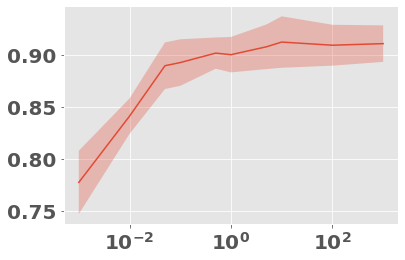

In [115]:
plot_scores(gs_logistic_balanced)

Протестируем обученную модель и применим различные метрики оценки точности модели

In [116]:
# Выполним предсказание на тестовом наборе данных
preds_logistic_balanced = gs_logistic_balanced.predict(X_test)

In [117]:
# Используем classification_report
print(metrics.classification_report(y_test, preds_logistic_balanced))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       101
           1       0.83      0.71      0.77         7
           4       0.71      0.56      0.63         9

    accuracy                           0.93       117
   macro avg       0.83      0.75      0.79       117
weighted avg       0.93      0.93      0.93       117



Confusion matrix:
[[99  1  1]
 [ 1  5  1]
 [ 4  0  5]]


Text(0.5, 42.0, 'Predicted value')

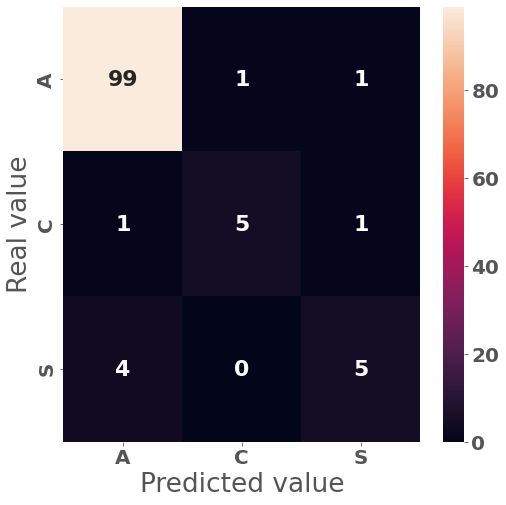

In [118]:
# Построим confusion matrix
fig = plt.figure(figsize=(8, 8))
nn_mtx = metrics.confusion_matrix(y_test, preds_logistic_balanced)
print('Confusion matrix:')
print(nn_mtx)
font = {'weight': 'bold', 'size': 22}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d",
            xticklabels=encoders["AGEGROUP"].classes_[[0, 1, 4]], 
            yticklabels=encoders["AGEGROUP"].classes_[[0, 1, 4]])
plt.ylabel("Real value")
plt.xlabel("Predicted value")

In [119]:
# Используем метрику Accuracy
metrics.accuracy_score(y_test, preds_logistic_balanced)

0.9316239316239316

##Определение возраста методом gradient boosting с использованием библиотеки CatBoost

Установим CatBoost

In [120]:
!pip install catboost

     |████████████████████████████████| 65.8MB 62kB/s 


In [121]:
# Импорт модулей необходимых для модели
from numpy import mean
from numpy import std
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

Подготовим наш датасет для обучения и тестирования модели

Для этого удалим из датасета со средним возрастом (целевая функция) категориальные признаки, оставив только измерения краниального и посткраниального скелета.

Удалим записи с большим числом незаполненых измерений, а также строки с пустыми значениями целевой функции и заменим средними значениями остальные ячейки с None.



In [122]:
# Удаляем неиспользуемые столбцы
df_regression = df.drop(columns=['AGEGROUP', 'RACE', 'SEX', 'FDN', 'CONTRIB',
                                 'CURATOR', 'RECORDER', 'DATEREC', 'IDSTAT',
                                 'SEXSTAT', 'RACESTAT', 'ETHNIC', 'DOB_MODA',
                                 'DOB_YR', 'DEATHAGE', 'LOWERAGE', 'UPPERAGE',
                                 'FSTATURE', 'CSTATURE', 'FWEIGHT', 'CWEIGHT',
                                 'DATPOSID'])
# Удаляем строки с малым числом измерений в нашем датафрейме
df_regression = drop_null_records(df_regression)
# В оставшихся записях заменям NaN средним по столбцу
df_regression.fillna(df_regression.mean(), inplace=True)
# Удалим столбцы с высоким коэффициентом корреляции 
df_regression = df_regression.drop(columns=['RADXLN_L', 'FEMXLN_L', 'FIBXLN_R'])
# Удалим строки с None в столбцах, которые будем использовать в целевой функции
df_regression = df_regression.dropna(axis=0)

Количество измерений в исходном DataFrame: 121


(array([ 7.,  6.,  5., 14., 24., 63., 83., 61., 53., 53., 66., 43., 39.,
        37., 24., 30., 20., 29., 17., 17., 21., 21., 17.,  9.,  6.,  2.,
         2.,  1.,  0., 25.]),
 array([ 0. ,  3.3,  6.6,  9.9, 13.2, 16.5, 19.8, 23.1, 26.4, 29.7, 33. ,
        36.3, 39.6, 42.9, 46.2, 49.5, 52.8, 56.1, 59.4, 62.7, 66. , 69.3,
        72.6, 75.9, 79.2, 82.5, 85.8, 89.1, 92.4, 95.7, 99. ]),
 <a list of 30 Patch objects>)

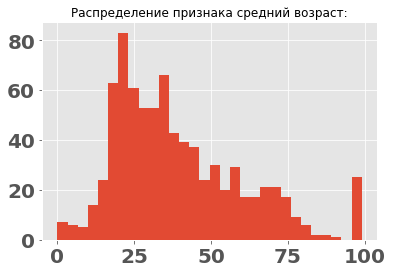

In [123]:
# Рассмотрим распределение целевой функции
plt.title('Распределение признака средний возраст:', fontsize=12)
plt.hist(df_regression['AVERAGEAGE'], bins=30)

(array([ 7.,  6.,  5., 10., 20., 37., 76., 54., 66., 59., 41., 54., 39.,
        42., 26., 27., 33., 17., 21., 27., 14., 16., 16., 20., 17.,  7.,
         6.,  4.,  2.,  1.]),
 array([ 0.        ,  3.03333333,  6.06666667,  9.1       , 12.13333333,
        15.16666667, 18.2       , 21.23333333, 24.26666667, 27.3       ,
        30.33333333, 33.36666667, 36.4       , 39.43333333, 42.46666667,
        45.5       , 48.53333333, 51.56666667, 54.6       , 57.63333333,
        60.66666667, 63.7       , 66.73333333, 69.76666667, 72.8       ,
        75.83333333, 78.86666667, 81.9       , 84.93333333, 87.96666667,
        91.        ]),
 <a list of 30 Patch objects>)

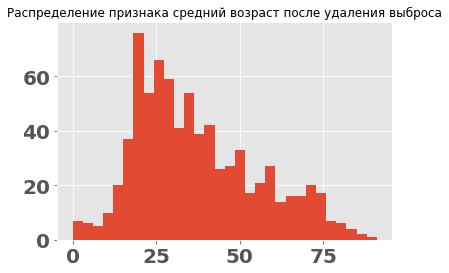

In [124]:
# Значение 99 - явный выброс - удалим записи с указанным значением целевой функции
df_regression = df_regression[df_regression['AVERAGEAGE'] != 99.]
plt.title('Распределение признака средний возраст после удаления выброса', fontsize=12)
plt.hist(df_regression['AVERAGEAGE'], bins=30)

Выделим целевую функцию в отдельную переменную, преобразуем DataFrame в формат для обучения модели и масштабируем признаки

In [125]:
# Выделим целевую функцию в отдельную переменную
y_3 = np.array(df_regression['AVERAGEAGE'])

In [126]:
# Преобразуем DataFrame в формат для обучения модели (np.array)
df_regression = df_regression.drop(columns='AVERAGEAGE')
X = np.array(df_regression)
# Масштабируем признаки
from sklearn.preprocessing import scale
X_norm = scale(X)
X_norm

array([[-1.37826393e+00, -1.66085714e+00, -2.08055594e+00, ...,
         1.73070538e-03, -7.00338693e-04, -4.27093107e-03],
       [ 2.73774477e-01,  7.99944335e-03,  7.28737040e-03, ...,
         5.70693936e-01,  1.66438562e+00,  1.25363472e+00],
       [-1.26026119e+00, -7.80396467e-01,  1.93436473e-01, ...,
         1.83336925e+00,  1.29068735e+00,  1.25363472e+00],
       ...,
       [ 1.33579917e+00, -7.60279243e-02,  3.45035968e-01, ...,
         1.73070538e-03,  9.16989082e-01, -4.27093107e-03],
       [ 1.09979368e+00, -4.28212196e-01, -2.61362010e-01, ...,
         7.81139821e-01, -5.77803995e-01, -2.84235573e-01],
       [ 3.77689899e-02, -6.04304331e-01,  1.55783192e+00, ...,
         1.73070538e-03,  1.66438562e+00, -4.27093107e-03]])

Разобьем выборку на тестовую и тренировочную

In [127]:
# Разобъем выборку на тестовую и тренировочную
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_3, test_size=0.15,
                                                    random_state=42)

Создадим и обучим модель

In [128]:
# Создаем модель
model = CatBoostRegressor(verbose=0, n_estimators=100)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, 
                           scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1,
                           error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# Обучаем модель
model = CatBoostRegressor(verbose=0, n_estimators=100)
model.fit(X_train, y_train)

MAE: -11.441 (1.007)


Выполним предсказание


In [129]:
# Выполним предсказание
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

Построим столбчатую диаграмму сравнения предсказанного возраста (зеленые столбцы) с тестовыми значениями (синие столбцы)

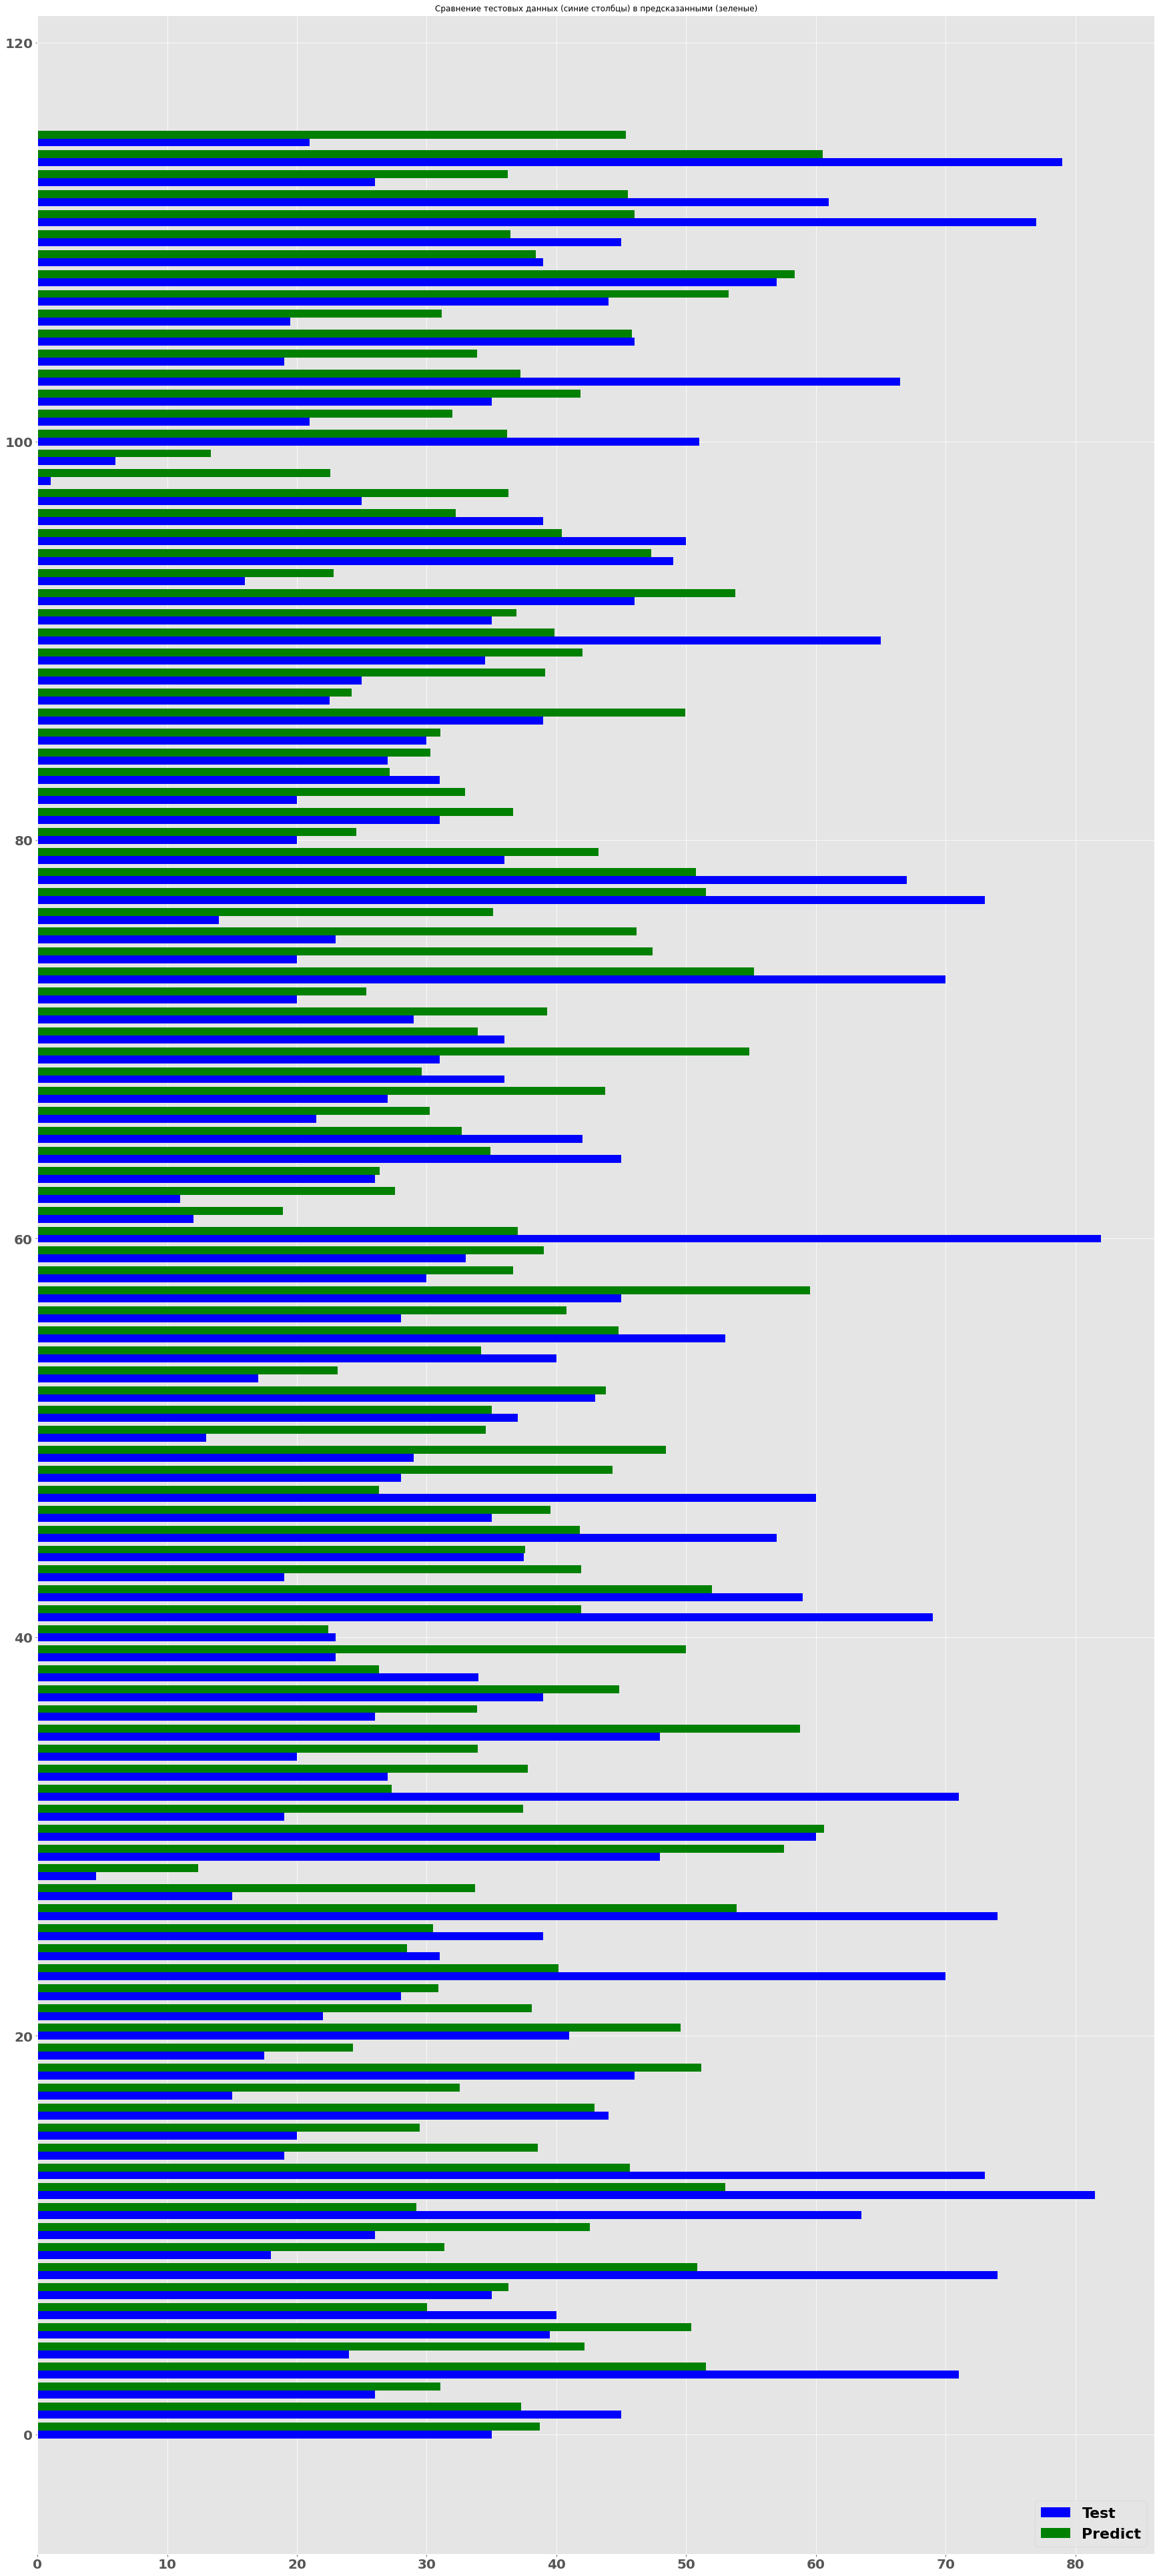

In [130]:
# Построим столбчатую диаграмму сравнения предсказанного возраста с тестовыми значениями
index = np.arange(len(y_test))
bw = 0.4
plt.figure(figsize = (30, 70))
plt.title('Сравнение тестовых данных (синие столбцы) в предсказанными (зеленые)',
          fontsize=12)
plt.barh(index, y_test, bw, color='b', label='Test')
plt.barh(index+bw, y_pred_test, bw, color='g', label='Predict')
plt.legend(loc='lower right')
plt.show()

## Выводы





*   Используя бинарную классификацию методом логистической регрессии из библиотеки scikit-learn мы получили достаточно точную (для данного набора данных модель), позволяющую предсказать пол индивида.
*   Метод к ближайших соседей позволил определить расу по результатам измерений. Ошибки при предсказаниях можно объяснить тем, что раса на этапе формирования датасета для людей переходных рас указывается весьма условно.
*   Сбалансированная логистическая регрессия для определения возрастной группы позволила получить результат с высокой точностью.
*   Используя метод методом gradient boosting с использованием библиотеки CatBoostRegressor из библиотеки CatBoost мы получили вполне удовлетворительные результаты предсказания возраста индивида по измерениям его костных останков для возрастов более 10 и менее 50 лет. Более значительные расхождения тестовых и предсказанных значений для возраста до 10 лет объясняются большей вариабельностью значений в этом возрасте. А после 50 лет изменения в краниальном и постраниальном скелете уже минимальные.

